# Final Multi-Scale Unet Model Train - Test Script

In [1]:
!git clone https://github.com/harshit-iitr/VLG_Pixel_play

Cloning into 'VLG_Pixel_play'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 200 (delta 31), reused 6 (delta 2), pack-reused 147 (from 1)
Receiving objects: 100% (200/200), 496.77 MiB | 41.87 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (155/155), done.


In [3]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/rotnet_model.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda
Found 11706 frames to process.


Cleaning: 100%|██████████| 11706/11706 [03:33<00:00, 54.83it/s]

------------------------------
Cleaning Complete!
Total Images: 11706
Images Flipped/Fixed: 1195
Cleaned dataset saved to: /kaggle/working/cleaned_testing_videos


## Noise remover using FastDVDnet (test)

In [4]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_test"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

Cloning into 'fastdvdnet'...


🛠️ Cloning FastDVDnet...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00


--2026-01-07 13:48:54--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-07 13:48:55--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘fastdvdnet/model/model.pth’

     0K .......... .......... .......... .......... ..........  0% 3.67M 3s
    50K .......... .......... .......... .......... ..........  1% 4.53M 2s
   100K .......... .......... ........

🌍 Found 21 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 76/76 [01:14<00:00,  1.03it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 47/47 [00:45<00:00,  1.03it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 60/60 [00:59<00:00,  1.00it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 37/37 [00:37<00:00,  1.01s/it]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 23/23 [00:24<00:00,  1.04s/it]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 46/46 [00:46<00:00,  1.00s/it]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 33/33 [00:33<00:00,  1.03s/it]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:31<00:00,  1.03s/it]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 47/47 [00:46<00:00,  1.01it/s]



🎬 Processing Video: 17


Cleaning 17: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]



🎬 Processing Video: 18


Cleaning 18: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]



🎬 Processing Video: 19


Cleaning 19: 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]



🎬 Processing Video: 20


Cleaning 20: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]



🎬 Processing Video: 21


Cleaning 21: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_test


## Noise remover using FastDVDnet (train)

In [ ]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_train"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

## Training scrpit

In [5]:
%cd /kaggle/working

/kaggle/working


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/working/denoised_dataset_train'
SAVE_PATH = 'multiscale_unet_conditional.pth'

IMG_SIZE = 256
CLIP_LEN = 4     # 4 frames input
BATCH_SIZE = 16  # 8 per GPU
EPOCHS = 50
LR_G = 2e-4
LR_D = 2e-5

# [cite_start]Loss Weights [cite: 2419, 2782]
LAMBDA_INT = 2.0
LAMBDA_GD = 1.0
LAMBDA_ADV = 0.05
LAMBDA_FLOW = 2.0 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. ARCHITECTURE COMPONENTS (Generator) ---
# [Unchanged from previous robust implementation]

class AsymmetricConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(AsymmetricConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size//2, 0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size//2))
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.bn(self.conv2(self.relu(self.conv1(x)))))

class ResidualSkipConnection(nn.Module):
    def __init__(self, channels):
        super(ResidualSkipConnection, self).__init__()
        self.block = nn.Sequential(
            AsymmetricConv(channels, channels),
            AsymmetricConv(channels, channels)
        )
        self.shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.block(x) + self.shortcut(x))

class ShortcutInceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutInceptionModule, self).__init__()
        w_6 = out_channels // 6
        w_3 = out_channels // 3
        w_2 = out_channels - (w_6 + w_3)

        self.branch1 = AsymmetricConv(in_channels, w_6)
        self.branch2 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3))
        self.branch3 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3), AsymmetricConv(w_3, w_2))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        concat = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1)
        return self.relu(concat + self.shortcut(x))

class MultiScaleUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=3):
        super(MultiScaleUNet, self).__init__()
        # Encoder
        self.sim1 = ShortcutInceptionModule(in_channels, 96); self.pool1 = nn.MaxPool2d(2)
        self.sim2 = ShortcutInceptionModule(96, 192);         self.pool2 = nn.MaxPool2d(2)
        self.sim3 = ShortcutInceptionModule(192, 384);        self.pool3 = nn.MaxPool2d(2)
        self.sim4 = ShortcutInceptionModule(384, 768)

        # Skip Connections
        self.rsc1 = nn.Sequential(*[ResidualSkipConnection(96) for _ in range(4)])
        self.rsc2 = nn.Sequential(*[ResidualSkipConnection(192) for _ in range(3)])
        self.rsc3 = nn.Sequential(*[ResidualSkipConnection(384) for _ in range(2)])

        # Decoder
        self.sim5 = ShortcutInceptionModule(768, 384);   self.up1 = nn.ConvTranspose2d(384, 384, 2, 2)
        self.sim6 = ShortcutInceptionModule(768, 192);   self.up2 = nn.ConvTranspose2d(192, 192, 2, 2)
        self.sim7 = ShortcutInceptionModule(384, 96);    self.up3 = nn.ConvTranspose2d(96, 96, 2, 2)
        self.sim8 = ShortcutInceptionModule(192, 96)
        self.final = nn.Conv2d(96, out_channels, 3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        e1 = self.sim1(x);        p1 = self.pool1(e1)
        e2 = self.sim2(p1);       p2 = self.pool2(e2)
        e3 = self.sim3(p2);       p3 = self.pool3(e3)
        e4 = self.sim4(p3)

        d1 = self.sim5(e4);       u1 = self.up1(d1)
        cat1 = torch.cat([u1, self.rsc3(e3)], dim=1)

        d2 = self.sim6(cat1);     u2 = self.up2(d2)
        cat2 = torch.cat([u2, self.rsc2(e2)], dim=1)

        d3 = self.sim7(cat2);     u3 = self.up3(d3)
        cat3 = torch.cat([u3, self.rsc1(e1)], dim=1)

        d4 = self.sim8(cat3)
        return self.tanh(self.final(d4))

# --- 2. CONDITIONAL PATCH DISCRIMINATOR (FIXED) ---
class ConditionalPatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6): # 3 (Current) + 3 (Past Condition)
        super(ConditionalPatchDiscriminator, self).__init__()
        
        def disc_block(in_f, out_f, bn=True):
            block = [nn.Conv2d(in_f, out_f, 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True)]
            if bn: block.append(nn.BatchNorm2d(out_f))
            return block

        self.model = nn.Sequential(
            *disc_block(in_channels, 64, bn=False), # 128x128
            *disc_block(64, 128),                   # 64x64
            *disc_block(128, 256),                  # 32x32
            nn.Conv2d(256, 1, 4, padding=1)         # 32x32 (PatchGAN Map)
        )

    def forward(self, img_A, img_B):
        # Concatenate condition (Last Frame) and target (Current Frame)
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# --- 3. LOSSES ---
def gradient_loss(gen_frames, gt_frames):
    def gradient(x):
        h_x = x.size()[-2]
        w_x = x.size()[-1]
        x_h = torch.abs(x[:, :, 1:, :] - x[:, :, :h_x-1, :])
        x_w = torch.abs(x[:, :, :, 1:] - x[:, :, :, :w_x-1])
        return x_h, x_w
    gen_h, gen_w = gradient(gen_frames)
    gt_h, gt_w = gradient(gt_frames)
    return torch.mean(torch.abs(gen_h - gt_h)) + torch.mean(torch.abs(gen_w - gt_w))

def flow_loss(gen_frames, gt_frames, prev_frames):
    flow_gen = torch.abs(gen_frames - prev_frames)
    flow_gt = torch.abs(gt_frames - prev_frames)
    return torch.mean(torch.abs(flow_gen - flow_gt)) # L1 Loss for robustness

# --- 4. DATASET ---
class AvenueTrainDataset(Dataset):
    def __init__(self, root_dir, clip_len=4, img_size=256):
        self.clip_len = clip_len
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        videos = sorted(os.listdir(root_dir))
        for vid in videos:
            path = os.path.join(root_dir, vid)
            if not os.path.isdir(path): continue
            frames = sorted(glob.glob(os.path.join(path, '*.jpg')))
            if len(frames) < clip_len + 1: continue
            
            for i in range(len(frames) - clip_len):
                self.samples.append(frames[i : i + clip_len + 1])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        paths = self.samples[idx]
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in paths]
        
        input_seq = torch.cat(imgs[:-1], dim=0) # 12 channels
        target_frame = imgs[-1]                 # 3 channels (t+1)
        last_input_frame = imgs[-2]             # 3 channels (t) - For Conditioning
        
        return input_seq, target_frame, last_input_frame

# --- 5. TRAINING LOOP (CONDITIONAL GAN) ---
def train():
    print(f"Initializing Conditional Multi-scale U-Net Training on {DEVICE}...")
    
    # Init Models
    generator = MultiScaleUNet().to(DEVICE)
    # Discriminator takes 6 channels: 3 (Condition/Last Frame) + 3 (Target/Generated)
    discriminator = ConditionalPatchDiscriminator(in_channels=6).to(DEVICE)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)
        
    opt_g = optim.Adam(generator.parameters(), lr=LR_G)
    opt_d = optim.Adam(discriminator.parameters(), lr=LR_D)
    
    criterion_gan = nn.MSELoss() # LSGAN is more stable than BCE
    criterion_pixel = nn.MSELoss()
    
    dataset = AvenueTrainDataset(TRAIN_DIR, CLIP_LEN, IMG_SIZE)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
    
    try:
        for epoch in range(EPOCHS):
            generator.train(); discriminator.train()
            pbar = tqdm(loader, desc=f"Ep {epoch+1}/{EPOCHS}")
            
            for inputs, targets, last_frames in pbar:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                last_frames = last_frames.to(DEVICE) # Condition for D
                
                # ==========================
                #  Train Discriminator (D)
                # ==========================
                opt_d.zero_grad()
                
                # Real: D(LastFrame, RealTarget) -> 1
                real_out = discriminator(last_frames, targets)
                loss_real = criterion_gan(real_out, torch.ones_like(real_out))
                
                # Fake: D(LastFrame, FakeTarget) -> 0
                fake_frame = generator(inputs)
                fake_out = discriminator(last_frames, fake_frame.detach()) # Detach G
                loss_fake = criterion_gan(fake_out, torch.zeros_like(fake_out))
                
                loss_d = 0.5 * (loss_real + loss_fake)
                loss_d.backward()
                opt_d.step()
                
                # ==========================
                #  Train Generator (G)
                # ==========================
                opt_g.zero_grad()
                
                # 1. Adversarial Loss: D(LastFrame, FakeTarget) -> 1
                fake_out_g = discriminator(last_frames, fake_frame)
                l_adv = criterion_gan(fake_out_g, torch.ones_like(fake_out_g))
                
                # 2. Pixel Intensity Loss
                l_int = criterion_pixel(fake_frame, targets)
                
                # 3. Gradient Loss
                l_gd = gradient_loss(fake_frame, targets)
                
                # 4. Flow Loss (Temporal Consistency)
                l_flow = flow_loss(fake_frame, targets, last_frames)
                
                # Total Loss
                loss_g = (LAMBDA_INT * l_int) + \
                         (LAMBDA_GD * l_gd) + \
                         (LAMBDA_ADV * l_adv) + \
                         (LAMBDA_FLOW * l_flow)
                         
                loss_g.backward()
                opt_g.step()
                
                pbar.set_postfix({
                    'D_loss': f"{loss_d.item():.4f}",
                    'G_Adv': f"{l_adv.item():.4f}",
                    'G_Int': f"{l_int.item():.4f}",
                    'G_Flow': f"{l_flow.item():.4f}"
                })
            
            torch.save(generator.module.state_dict(), f"unet_conditional_ep{epoch}.pth")
            
    except KeyboardInterrupt:
        print("\nTraining Interrupted! Saving checkpoint...")
        state = generator.module.state_dict() if hasattr(generator, 'module') else generator.state_dict()
        torch.save(state, 'INTERRUPTED_conditional.pth')
        print("Saved safely.")

if __name__ == "__main__":
    train()

## Testing Visualiser Script
use the weight from above training script or replace by the model file

Generating Anomaly Graph for Video 01 using /kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/unet_conditional_ep8.pth...
Loading frames from /kaggle/working/denoised_dataset_test/01...


100%|██████████| 31/31 [00:54<00:00,  1.76s/it]


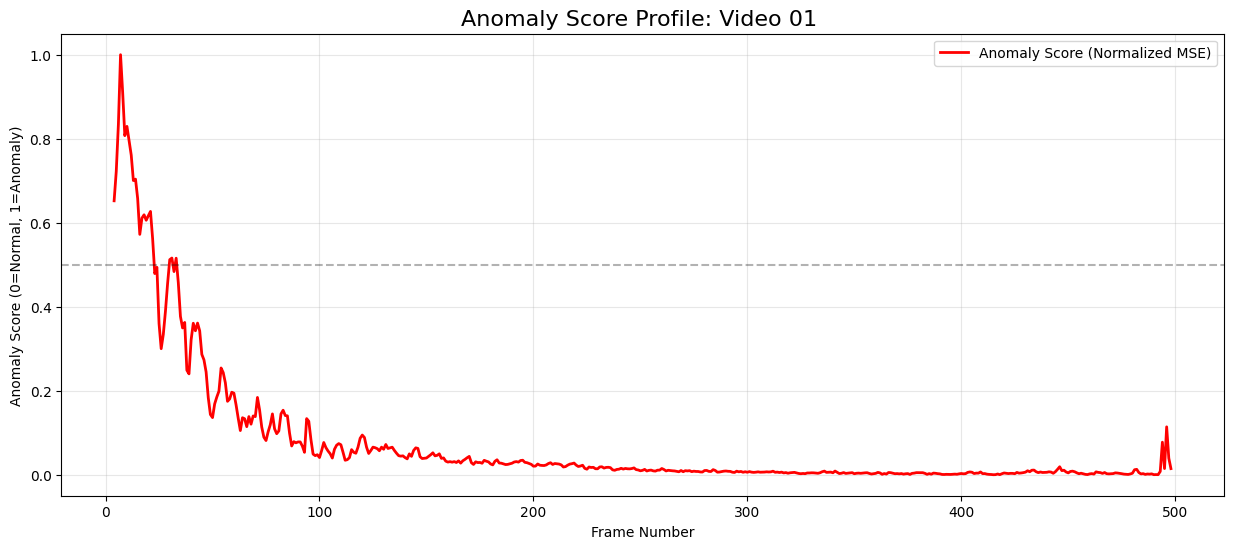

In [9]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
# Update this to match your actual file name
MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/unet_conditional_ep8.pth' 
TEST_DIR = '/kaggle/working/denoised_dataset_test'
TARGET_VIDEO = '01' 

IMG_SIZE = 256
CLIP_LEN = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. MODEL ARCHITECTURE (Must be defined to load weights) ---
class AsymmetricConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(AsymmetricConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size//2, 0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size//2))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x): return self.relu(self.bn(self.conv2(self.relu(self.conv1(x)))))

class ResidualSkipConnection(nn.Module):
    def __init__(self, channels):
        super(ResidualSkipConnection, self).__init__()
        self.block = nn.Sequential(AsymmetricConv(channels, channels), AsymmetricConv(channels, channels))
        self.shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.block(x) + self.shortcut(x))

class ShortcutInceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutInceptionModule, self).__init__()
        w_6 = out_channels // 6; w_3 = out_channels // 3; w_2 = out_channels - (w_6 + w_3)
        self.branch1 = AsymmetricConv(in_channels, w_6)
        self.branch2 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3))
        self.branch3 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3), AsymmetricConv(w_3, w_2))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1) + self.shortcut(x))

class MultiScaleUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=3):
        super(MultiScaleUNet, self).__init__()
        self.sim1 = ShortcutInceptionModule(in_channels, 96); self.pool1 = nn.MaxPool2d(2)
        self.sim2 = ShortcutInceptionModule(96, 192);         self.pool2 = nn.MaxPool2d(2)
        self.sim3 = ShortcutInceptionModule(192, 384);        self.pool3 = nn.MaxPool2d(2)
        self.sim4 = ShortcutInceptionModule(384, 768)
        self.rsc1 = nn.Sequential(*[ResidualSkipConnection(96) for _ in range(4)])
        self.rsc2 = nn.Sequential(*[ResidualSkipConnection(192) for _ in range(3)])
        self.rsc3 = nn.Sequential(*[ResidualSkipConnection(384) for _ in range(2)])
        self.sim5 = ShortcutInceptionModule(768, 384);   self.up1 = nn.ConvTranspose2d(384, 384, 2, 2)
        self.sim6 = ShortcutInceptionModule(768, 192);   self.up2 = nn.ConvTranspose2d(192, 192, 2, 2)
        self.sim7 = ShortcutInceptionModule(384, 96);    self.up3 = nn.ConvTranspose2d(96, 96, 2, 2)
        self.sim8 = ShortcutInceptionModule(192, 96)
        self.final = nn.Conv2d(96, out_channels, 3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.sim1(x); p1 = self.pool1(e1)
        e2 = self.sim2(p1); p2 = self.pool2(e2)
        e3 = self.sim3(p2); p3 = self.pool3(e3)
        e4 = self.sim4(p3)
        d1 = self.sim5(e4); u1 = self.up1(d1)
        d2 = self.sim6(torch.cat([u1, self.rsc3(e3)], dim=1)); u2 = self.up2(d2)
        d3 = self.sim7(torch.cat([u2, self.rsc2(e2)], dim=1)); u3 = self.up3(d3)
        d4 = self.sim8(torch.cat([u3, self.rsc1(e1)], dim=1))
        return self.tanh(self.final(d4))

# --- 2. SINGLE VIDEO DATASET ---
class SingleVideoDataset(Dataset):
    def __init__(self, vid_id, root_dir, clip_len=4, img_size=256):
        self.clip_len = clip_len
        self.samples = []
        
        # Locate Video
        vid_path = os.path.join(root_dir, vid_id)
        if not os.path.exists(vid_path):
            # Try finding folder with different zero-padding (e.g. '2' vs '02')
            candidates = [d for d in os.listdir(root_dir) if str(int(d)) == str(int(vid_id))]
            if candidates: vid_path = os.path.join(root_dir, candidates[0])
            else: raise ValueError(f"Video {vid_id} not found in {root_dir}")
            
        print(f"Loading frames from {vid_path}...")
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Create sliding windows
        if len(self.frames) >= clip_len + 1:
            for i in range(len(self.frames) - clip_len):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        # Input: [t, t+1, t+2, t+3]
        in_paths = self.frames[idx : idx + self.clip_len]
        # Target: [t+4]
        tgt_path = self.frames[idx + self.clip_len]
        
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        input_seq = torch.cat(imgs, dim=0) # (12, H, W)
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        
        return input_seq, target, idx + self.clip_len

# --- 3. PLOT LOGIC ---
def visualize():
    print(f"Generating Anomaly Graph for Video {TARGET_VIDEO} using {MODEL_PATH}...")
    
    # Load Model
    model = MultiScaleUNet().to(DEVICE)
    if not os.path.exists(MODEL_PATH):
        print(f"Error: {MODEL_PATH} not found. Please train first or check the path.")
        return
        
    st = torch.load(MODEL_PATH, map_location=DEVICE)
    # Handle DataParallel dict keys if needed
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    model.eval()
    
    # Data
    ds = SingleVideoDataset(TARGET_VIDEO, TEST_DIR, CLIP_LEN, IMG_SIZE)
    loader = DataLoader(ds, batch_size=16, shuffle=False, num_workers=2)
    
    frame_indices = []
    errors = []
    
    # Inference
    with torch.no_grad():
        for inputs, targets, idxs in tqdm(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            preds = model(inputs)
            
            # Calculate Reconstruction Error (MSE) per frame
            # (Batch, C, H, W) -> Mean over (C, H, W) -> (Batch)
            mse = ((preds - targets)**2).mean(dim=(1,2,3)).cpu().numpy()
            
            errors.extend(mse)
            frame_indices.extend(idxs.numpy())
            
    # Process Scores
    scores = np.array(errors)
    
    # Normalize [0, 1] for this video (Crucial for AP!)
    mn, mx = scores.min(), scores.max()
    if mx > mn:
        scores_norm = (scores - mn) / (mx - mn)
    else:
        scores_norm = scores
        
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(frame_indices, scores_norm, color='red', linewidth=2, label='Anomaly Score (Normalized MSE)')
    
    plt.title(f"Anomaly Score Profile: Video {TARGET_VIDEO} ", fontsize=16)
    plt.xlabel("Frame Number")
    plt.ylabel("Anomaly Score (0=Normal, 1=Anomaly)")
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    visualize()

## Submission script generation

In [10]:
import os
import glob
import re
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn

# ================= CONFIGURATION =================
MODEL_PATH = '/kaggle/working/VLG_Pixel_play/Final_Codes/Final_models/unet_conditional_ep8.pth' 
CLEAN_DIR = '/kaggle/working/denoised_dataset_test' 

# Path to original noisy frames (for correct IDs like 939)
# CONFIRM THIS PATH IS CORRECT on your system
ORIGINAL_TEST_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

SUBMISSION_FILE = 'submission.csv'

IMG_SIZE = 256
CLIP_LEN = 4
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- HELPER: NATURAL SORT ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- 1. MODEL ARCHITECTURE ---
class AsymmetricConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(AsymmetricConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size//2, 0))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size//2))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x): return self.relu(self.bn(self.conv2(self.relu(self.conv1(x)))))

class ResidualSkipConnection(nn.Module):
    def __init__(self, channels):
        super(ResidualSkipConnection, self).__init__()
        self.block = nn.Sequential(AsymmetricConv(channels, channels), AsymmetricConv(channels, channels))
        self.shortcut = nn.Conv2d(channels, channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.block(x) + self.shortcut(x))

class ShortcutInceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutInceptionModule, self).__init__()
        w_6 = out_channels // 6; w_3 = out_channels // 3; w_2 = out_channels - (w_6 + w_3)
        self.branch1 = AsymmetricConv(in_channels, w_6)
        self.branch2 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3))
        self.branch3 = nn.Sequential(AsymmetricConv(in_channels, w_6), AsymmetricConv(w_6, w_3), AsymmetricConv(w_3, w_2))
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(torch.cat([self.branch1(x), self.branch2(x), self.branch3(x)], dim=1) + self.shortcut(x))

class MultiScaleUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=3):
        super(MultiScaleUNet, self).__init__()
        self.sim1 = ShortcutInceptionModule(in_channels, 96); self.pool1 = nn.MaxPool2d(2)
        self.sim2 = ShortcutInceptionModule(96, 192);         self.pool2 = nn.MaxPool2d(2)
        self.sim3 = ShortcutInceptionModule(192, 384);        self.pool3 = nn.MaxPool2d(2)
        self.sim4 = ShortcutInceptionModule(384, 768)
        self.rsc1 = nn.Sequential(*[ResidualSkipConnection(96) for _ in range(4)])
        self.rsc2 = nn.Sequential(*[ResidualSkipConnection(192) for _ in range(3)])
        self.rsc3 = nn.Sequential(*[ResidualSkipConnection(384) for _ in range(2)])
        self.sim5 = ShortcutInceptionModule(768, 384);   self.up1 = nn.ConvTranspose2d(384, 384, 2, 2)
        self.sim6 = ShortcutInceptionModule(768, 192);   self.up2 = nn.ConvTranspose2d(192, 192, 2, 2)
        self.sim7 = ShortcutInceptionModule(384, 96);    self.up3 = nn.ConvTranspose2d(96, 96, 2, 2)
        self.sim8 = ShortcutInceptionModule(192, 96)
        self.final = nn.Conv2d(96, out_channels, 3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.sim1(x); p1 = self.pool1(e1)
        e2 = self.sim2(p1); p2 = self.pool2(e2)
        e3 = self.sim3(p2); p3 = self.pool3(e3)
        e4 = self.sim4(p3)
        d1 = self.sim5(e4); u1 = self.up1(d1)
        d2 = self.sim6(torch.cat([u1, self.rsc3(e3)], dim=1)); u2 = self.up2(d2)
        d3 = self.sim7(torch.cat([u2, self.rsc2(e2)], dim=1)); u3 = self.up3(d3)
        d4 = self.sim8(torch.cat([u3, self.rsc1(e1)], dim=1))
        return self.tanh(self.final(d4))

# --- 2. DATASET (Reads CLEANED frames) ---
class CleanVideoDataset(Dataset):
    def __init__(self, vid_id, root_dir, clip_len=4, img_size=256):
        self.clip_len = clip_len
        self.samples = []
        vid_path = os.path.join(root_dir, vid_id)
        # Assumes frame_0000.jpg format (from FastDVDnet output)
        self.frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        if len(self.frames) >= clip_len + 1:
            for i in range(len(self.frames) - clip_len):
                self.samples.append(i)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        in_paths = self.frames[idx : idx + self.clip_len]
        tgt_path = self.frames[idx + self.clip_len]
        imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        input_seq = torch.cat(imgs, dim=0)
        target = self.transform(Image.open(tgt_path).convert('RGB'))
        return input_seq, target

# --- 3. MAIN LOGIC ---
def extract_frame_id(filename):
    """
    Extracts 939 from 'frame_00939.jpg' or '939.jpg'
    """
    # Regex to find the LAST sequence of digits in the filename
    match = re.search(r'(\d+)', os.path.splitext(filename)[0])
    if match:
        return int(match.group(1))
    return None

def generate_final_submission():
    print("🚀 Generating Final Corrected Submission...")
    
    # 1. Load Model
    model = MultiScaleUNet()
    if not os.path.exists(MODEL_PATH):
        print("❌ Model not found."); return
    
    st = torch.load(MODEL_PATH, map_location='cpu')
    if 'module.' in list(st.keys())[0]: st = {k.replace('module.', ''): v for k, v in st.items()}
    model.load_state_dict(st)
    model.to(DEVICE)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model.eval()
    
    # 2. Iterate Videos
    video_folders = sorted([f for f in os.listdir(CLEAN_DIR) if os.path.isdir(os.path.join(CLEAN_DIR, f))])
    all_results = []
    
    for vid_id in video_folders:
        print(f"🎬 Processing Video {vid_id}...", end=" ")
        
        # --- A. Get Correct Frame IDs from Original Folder ---
        orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, vid_id)
        if not os.path.exists(orig_vid_path):
             candidates = [d for d in os.listdir(ORIGINAL_TEST_DIR) if str(int(d)) == str(int(vid_id))]
             if candidates: orig_vid_path = os.path.join(ORIGINAL_TEST_DIR, candidates[0])
        
        # Grab all frames (frame_00939.jpg)
        orig_files = glob.glob(os.path.join(orig_vid_path, '*'))
        orig_files = [f for f in orig_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        orig_files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        # Extract Real IDs (e.g., 939, 940...)
        real_frame_ids = []
        for f in orig_files:
            fid = extract_frame_id(os.path.basename(f))
            if fid is not None:
                real_frame_ids.append(fid)
                
        if not real_frame_ids:
            print(f"⚠️ No frames found in original {vid_id}. Skipping.")
            continue
            
        # --- B. Inference ---
        ds = CleanVideoDataset(vid_id, CLEAN_DIR, CLIP_LEN, IMG_SIZE)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
        
        raw_scores = []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                preds = model(inputs)
                batch_mse = ((preds - targets)**2).mean(dim=(1,2,3)).cpu().numpy()
                raw_scores.extend(batch_mse)
        
        # --- C. Normalization ---
        scores_arr = np.array(raw_scores)
        if len(scores_arr) > 0:
            mn, mx = scores_arr.min(), scores_arr.max()
            if mx > mn: scores_norm = (scores_arr - mn) / (mx - mn)
            else: scores_norm = scores_arr
        else:
            scores_norm = []
        
        # --- D. Mapping ---
        # 1. The first 4 frames (CLIP_LEN) have NO prediction -> fill 0.0
        # 2. Prediction 0 aligns with Frame Index 4 (5th frame)
        
        count_mapped = 0
        for i, real_id in enumerate(real_frame_ids):
            if i < CLIP_LEN:
                # Fill buffer frames
                score = 0.0
            else:
                # Use prediction if available
                pred_idx = i - CLIP_LEN
                if pred_idx < len(scores_norm):
                    score = scores_norm[pred_idx]
                else:
                    score = 0.0 # Should not happen if lengths align
            
            all_results.append({
                'video_id': vid_id,
                'frame_id': real_id,
                'Predicted': float(score)
            })
            count_mapped += 1
            
        print(f"Done. ({count_mapped} frames)")

    # 3. Save
    df = pd.DataFrame(all_results)
    df['video_id'] = df['video_id'].astype(str)
    df.sort_values(by=['video_id', 'frame_id'], inplace=True)
    
    df.to_csv(SUBMISSION_FILE, index=False)
    print(f"\n✅✅✅ FINAL SUBMISSION SAVED: {SUBMISSION_FILE}")
    print("Example (Video 01):")
    print(df[df['video_id'].isin(['01', '1'])].head(6))

if __name__ == "__main__":
    generate_final_submission()


# ================= CONFIGURATION =================
# Path to the CSV you just generated (with video_id, frame_id, score)
INPUT_CSV = 'submission.csv' 
OUTPUT_CSV = 'submission_final.csv'
# =================================================

def format_submission():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    # 1. Ensure clean integer types
    # This automatically turns "01" into 1, handling the leading zero removal
    df['video_id'] = df['video_id'].astype(int)
    df['frame_id'] = df['frame_id'].astype(int)
    
    # 2. Create the merged 'ID' column (Format: 1_939)
    print("🔄 Merging columns to 'videoID_frameID' format...")
    df['ID'] = df['video_id'].astype(str) + "_" + df['frame_id'].astype(str)
    
    # 3. Select ONLY the required columns
    final_df = df[['ID', 'Predicted']]
    
    # 4. Fill any remaining NaNs with 0.0 (Just in case)
    final_df['Predicted'] = final_df['Predicted'].fillna(0.0)
    
    # 5. Save
    final_df.to_csv(OUTPUT_CSV, index=False)
    
    print(f"✅ SUCCESS! Final file saved to: {OUTPUT_CSV}")
    print("Example Rows:")
    print(final_df.head())

if __name__ == "__main__":
    format_submission()

🚀 Generating Final Corrected Submission...
🎬 Processing Video 01... Done. (499 frames)
🎬 Processing Video 02... Done. (1211 frames)
🎬 Processing Video 03... Done. (737 frames)
🎬 Processing Video 04... Done. (947 frames)
🎬 Processing Video 05... Done. (1007 frames)
🎬 Processing Video 06... Done. (627 frames)
🎬 Processing Video 07... Done. (588 frames)
🎬 Processing Video 08... Done. (36 frames)
🎬 Processing Video 09... Done. (359 frames)
🎬 Processing Video 10... Done. (722 frames)
🎬 Processing Video 11... Done. (472 frames)
🎬 Processing Video 12... Done. (735 frames)
🎬 Processing Video 13... Done. (528 frames)
🎬 Processing Video 14... Done. (496 frames)
🎬 Processing Video 15... Done. (732 frames)
🎬 Processing Video 16... Done. (740 frames)
🎬 Processing Video 17... Done. (417 frames)
🎬 Processing Video 18... Done. (275 frames)
🎬 Processing Video 19... Done. (229 frames)
🎬 Processing Video 20... Done. (273 frames)
🎬 Processing Video 21... Done. (76 frames)

✅✅✅ FINAL SUBMISSION SAVED: subm

/tmp/ipykernel_47/3403898042.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Predicted'] = final_df['Predicted'].fillna(0.0)


## Post-Processing

Sigmoid Normalising (good for visualisation)

📂 Loading /kaggle/working/submission_final.csv...
⚡ Applying Sigmoid (Center=0.07, Steepness=15)...
📸 Saved visualization to 'score_distribution_u_graph.png'


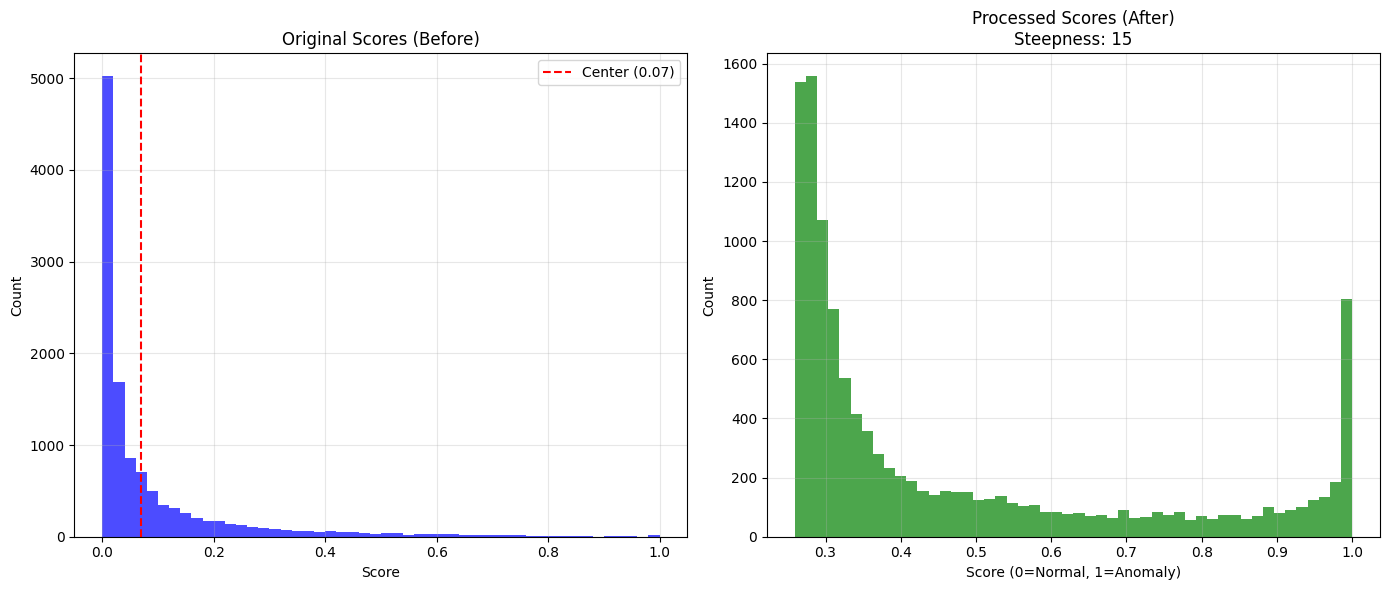

✅ Saved processed scores to submission_processed.csv
      ID  Predicted
0  1_939   0.259225
1  1_940   0.259225
2  1_941   0.259225
3  1_942   0.259225
4  1_943   0.999839


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_final.csv'
OUTPUT_CSV = 'submission_processed.csv'

# The "Center" of your sigmoid (The threshold between Normal vs Anomaly)
# You observed normals are < 0.1, so 0.1 is the tipping point.
CENTER = 0.07

# How hard to push values to 0 and 1.
# Low (e.g. 10) = Gentle S-curve
# High (e.g. 50) = Hard Step Function (Almost binary)
STEEPNESS = 15
# =================================================

def sigmoid_transform(x, center, k):
    """
    Custom Sigmoid:
    x: Input score array
    center: The value that maps to 0.5 (tipping point)
    k: Steepness coefficient
    """
    # 1. Shift x so the center is at 0
    shifted = x - center
    
    # 2. Scale by steepness
    scaled = k * shifted
    
    # 3. Apply standard sigmoid: 1 / (1 + e^-x)
    return 1 / (1 + np.exp(-scaled))

def process_and_visualize():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    original_scores = df['Predicted'].values
    
    # --- APPLY TRANSFORM ---
    print(f"⚡ Applying Sigmoid (Center={CENTER}, Steepness={STEEPNESS})...")
    new_scores = sigmoid_transform(original_scores, CENTER, STEEPNESS)
    
    df['Predicted'] = new_scores
    
    # --- VISUALIZATION (THE "U" GRAPH) ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Original Distribution
    plt.subplot(1, 2, 1)
    plt.hist(original_scores, bins=50, color='blue', alpha=0.7)
    plt.axvline(CENTER, color='red', linestyle='--', label=f'Center ({CENTER})')
    plt.title("Original Scores (Before)")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Processed Distribution (Should look like a U)
    plt.subplot(1, 2, 2)
    plt.hist(new_scores, bins=50, color='green', alpha=0.7)
    plt.title(f"Processed Scores (After)\nSteepness: {STEEPNESS}")
    plt.xlabel("Score (0=Normal, 1=Anomaly)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("score_distribution_u_graph.png")
    print("📸 Saved visualization to 'score_distribution_u_graph.png'")
    plt.show()
    
    # --- SAVE ---
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Saved processed scores to {OUTPUT_CSV}")
    print(df.head())

if __name__ == "__main__":
    process_and_visualize()

Anomaly window detection (smoothning)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# Use the file that gave you 0.66
INPUT_CSV = '/kaggle/working/submission_processed.csv' 
OUTPUT_CSV = 'submission_boosted_unet.csv'

# DILATION WINDOW
# Avenue is 25fps. Events last ~1-2 seconds.
# A window of 25 means we look +/- 12 frames around a peak.
WINDOW_SIZE = 20
# =================================================

def boost_score():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['ID'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print(f"Applying Peak Widening (Window={WINDOW_SIZE})...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].copy()
        
        # 1. ROLLING MAX (Dilation)
        # This spreads the '1.0' scores to their neighbors.
        # "If frame T is bad, then frame T+1 is probably bad too."
        dilated = raw.rolling(window=WINDOW_SIZE, center=True, min_periods=1).max()
        
        # 2. LIGHT SMOOTHING (Average)
        # Rolling max creates "blocky" steps. We smooth the edges slightly.
        smoothed = dilated.rolling(window=10, center=True, min_periods=1).mean()
        
        
        
        final_preds.extend(smoothed.values)
        
    df['Predicted'] = final_preds
    
    # Final Normalize (Safety)
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION ---
    # Let's see how much "fatter" the detection became
    v05 = df[df['ID'].str.startswith('05_')]
    if not v05.empty:
        x = v05['ID'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        
        # We need to reload original to compare
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['ID'].str.startswith('05_')]
        
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Original (0.66)')
        plt.plot(x, v05['Predicted'], color='green', linewidth=2, label='Widened (Boosted)')
        
        plt.title("Peak Widening Effect (Video 05)")
        plt.legend()
        plt.show()

    # Save
    out = df[['ID', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved boosted scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    boost_score()

Reading /kaggle/working/submission_processed.csv...
Applying Peak Widening (Window=20)...
Saved boosted scores to submission_boosted_unet.csv


This output is used in final essemble code.

## Final visualiser

📂 Loading /kaggle/working/submission_boosted_unet.csv...
🔄 Parsing data...
🌍 Visualizing 21 videos...
------------------------------


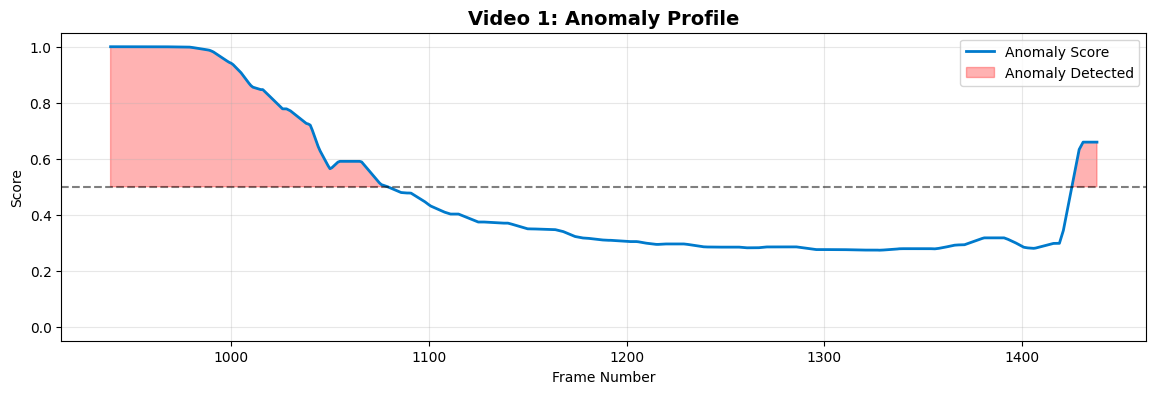

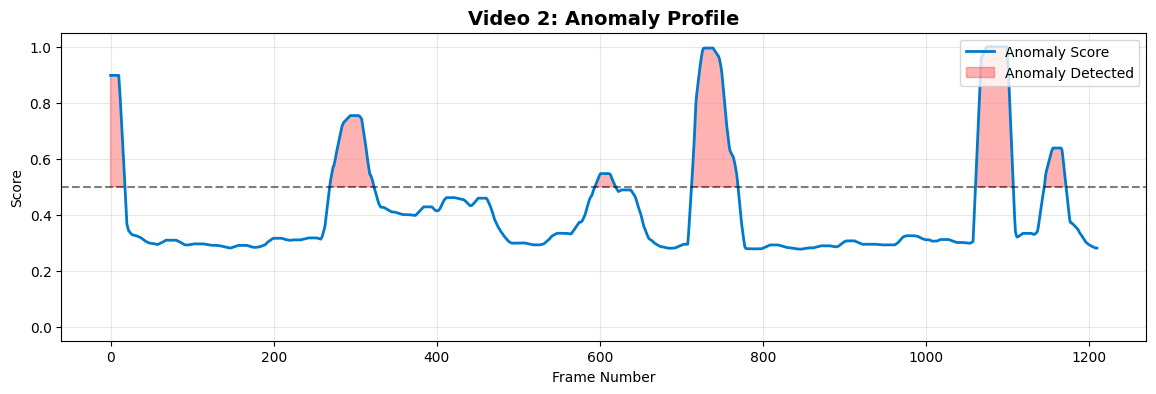

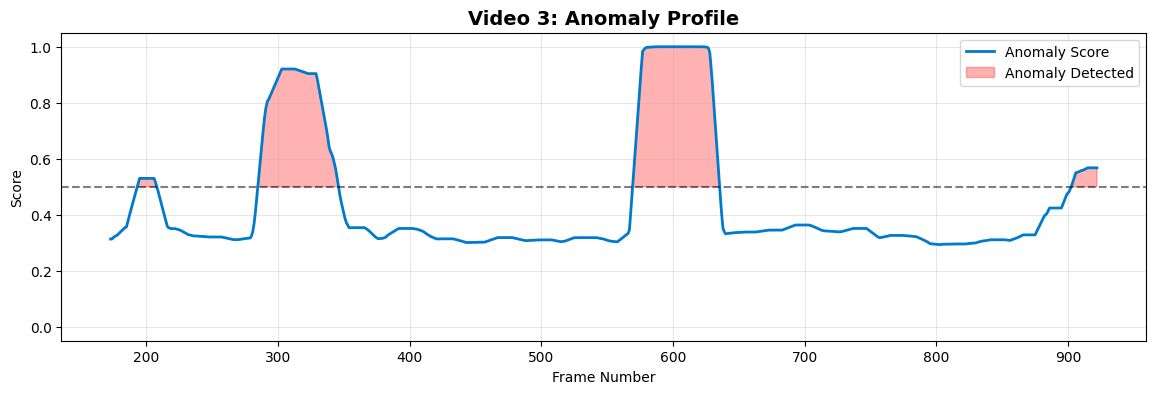

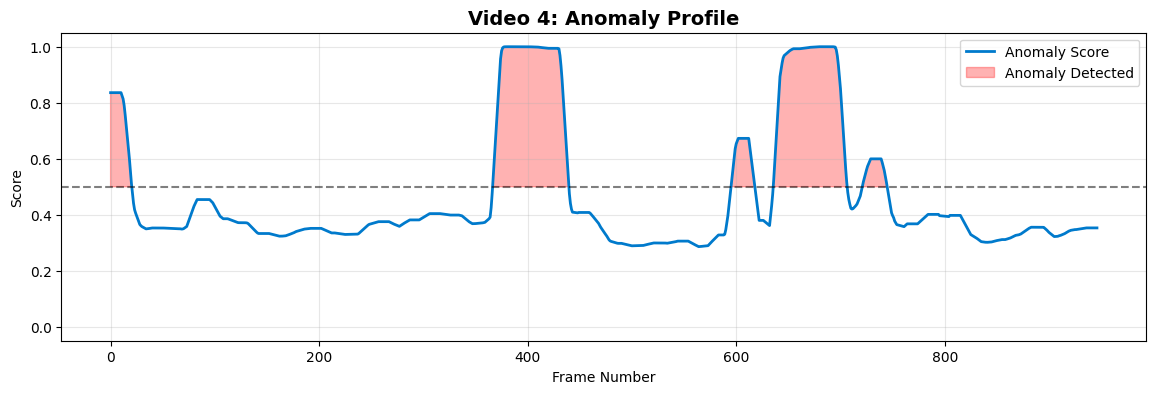

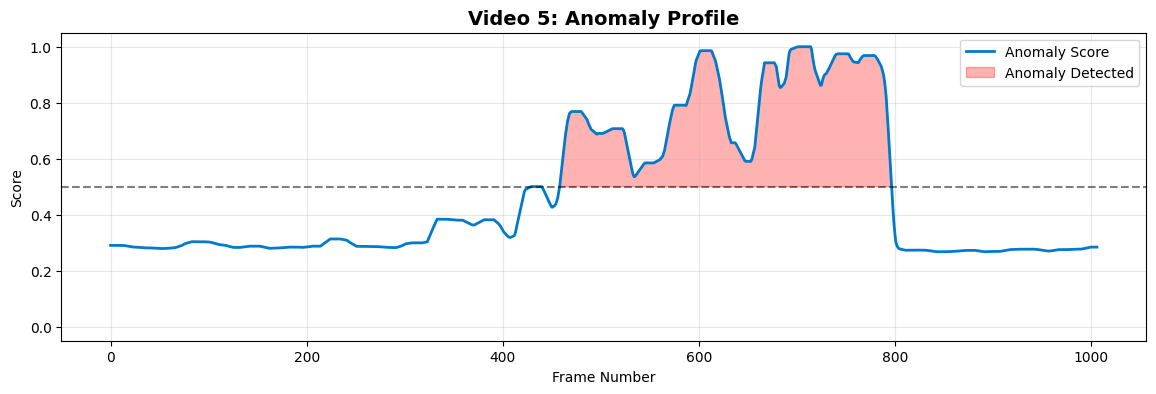

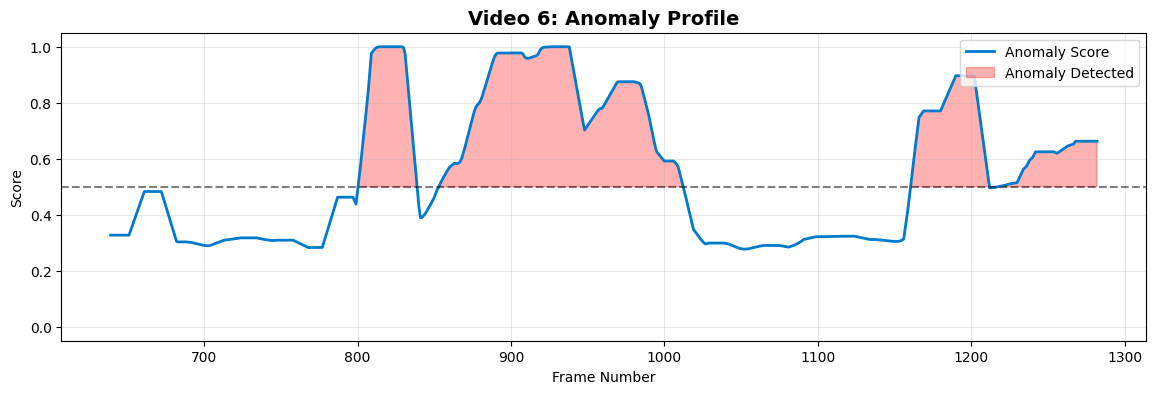

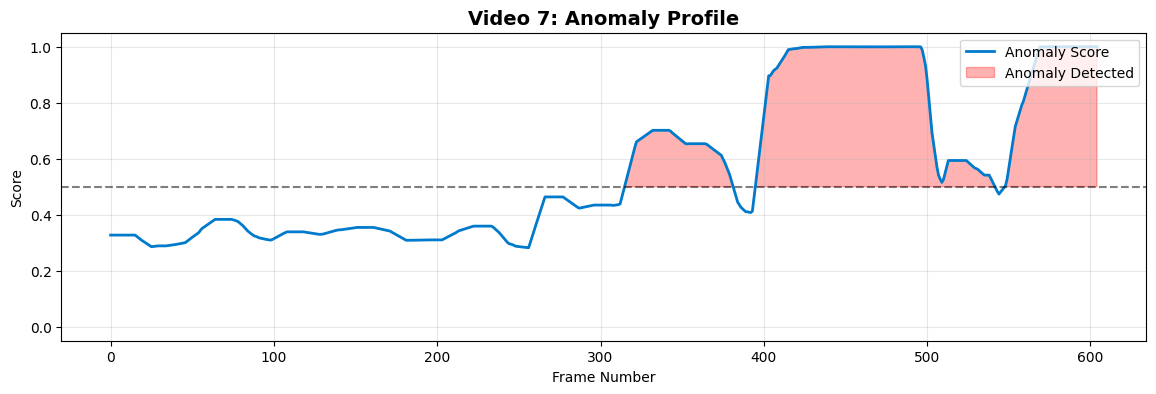

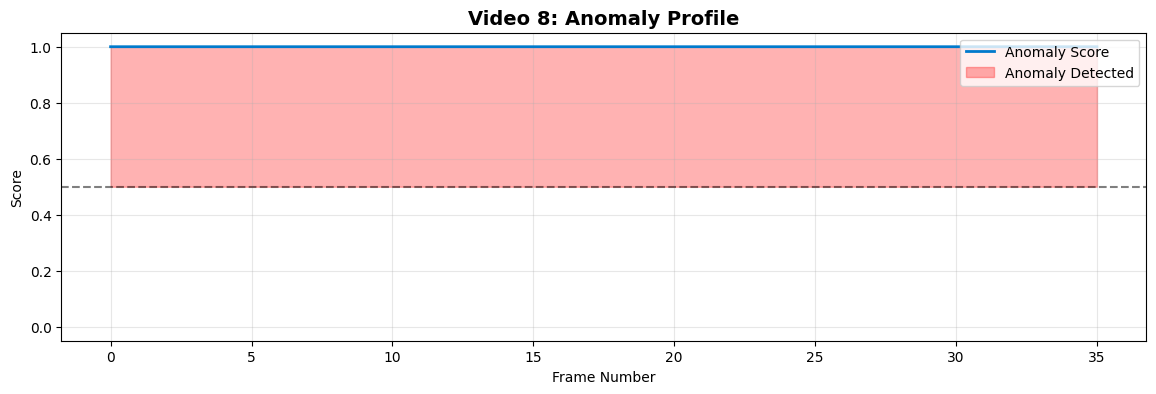

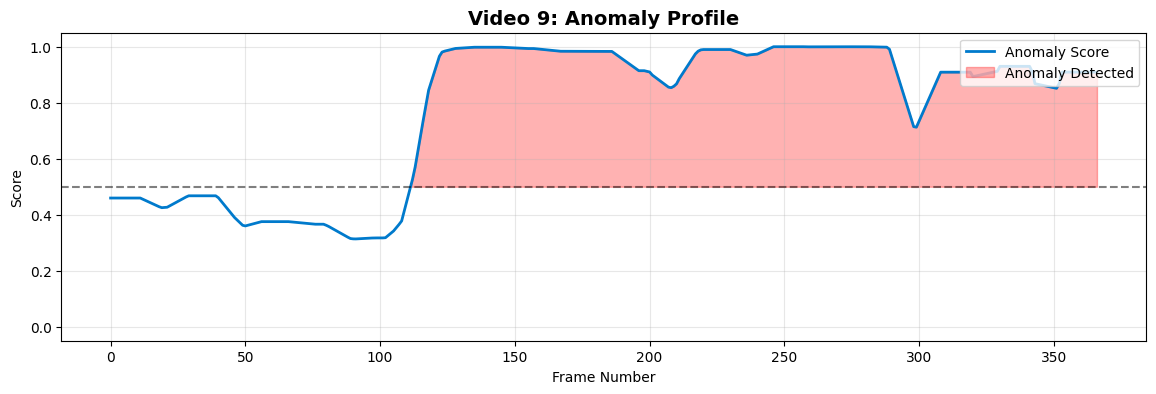

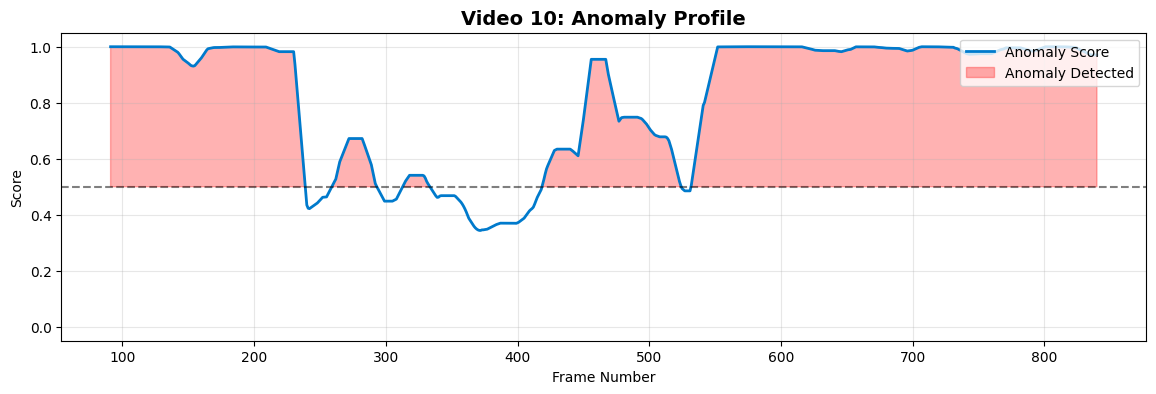

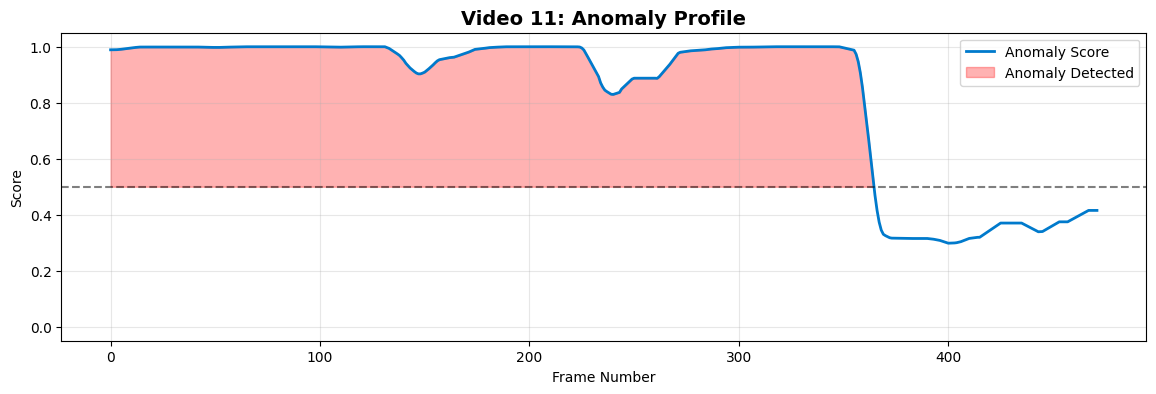

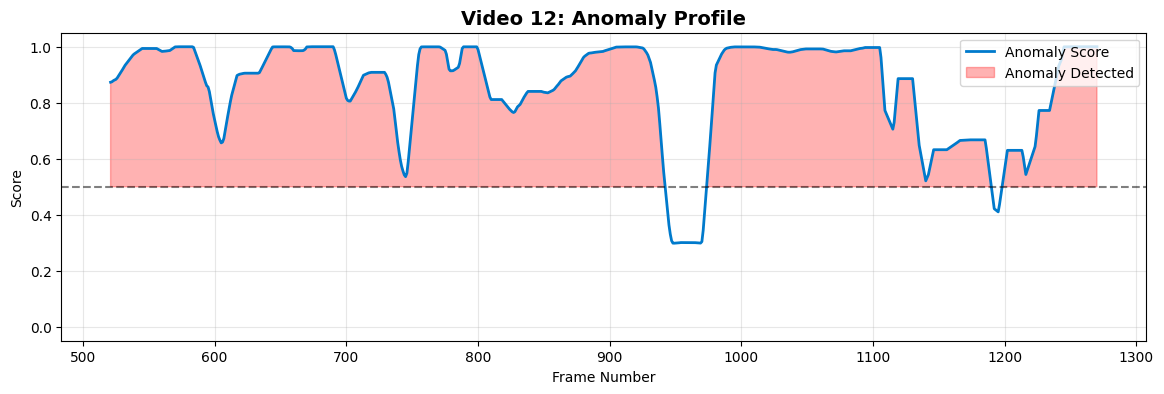

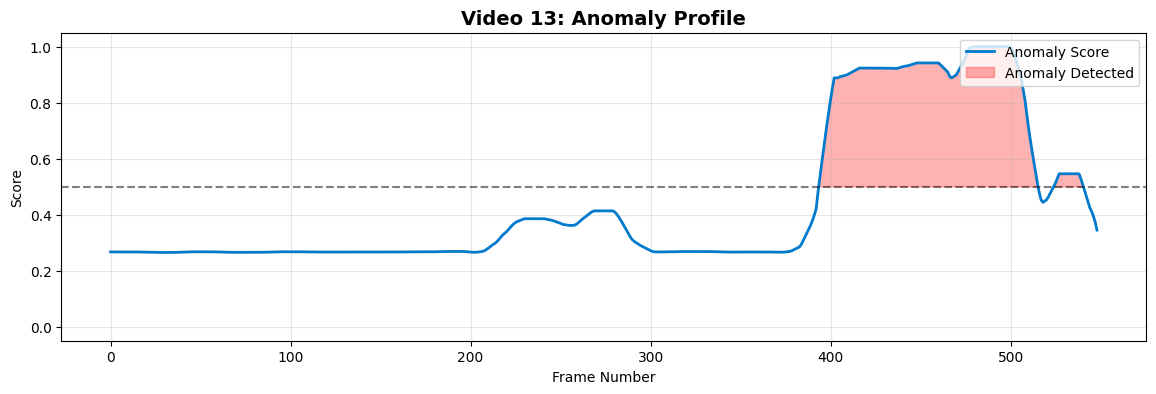

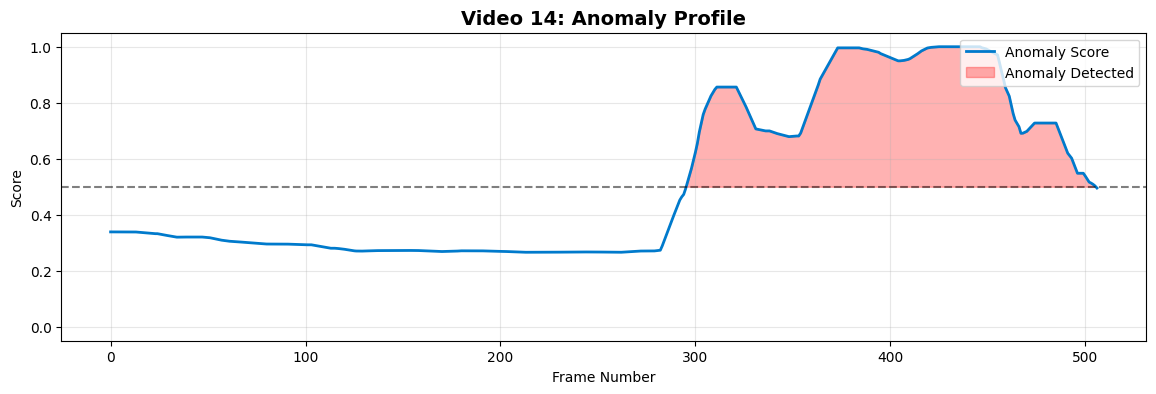

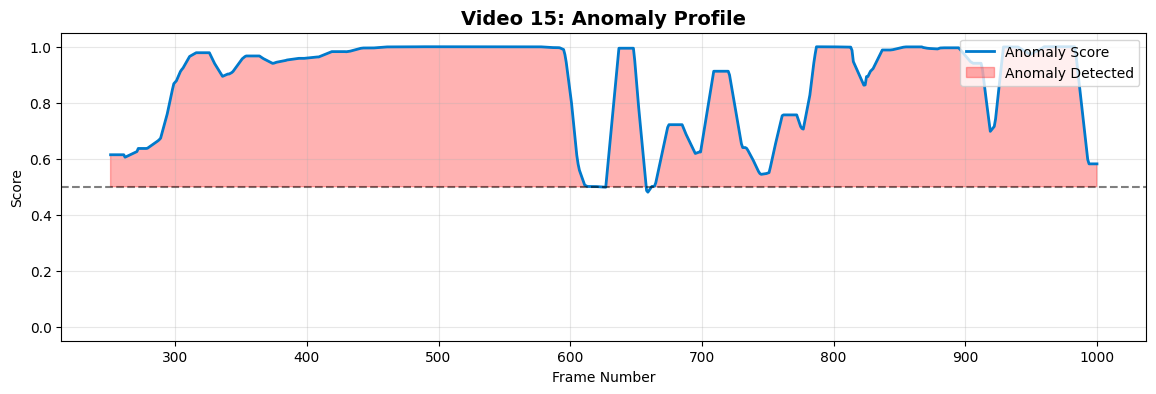

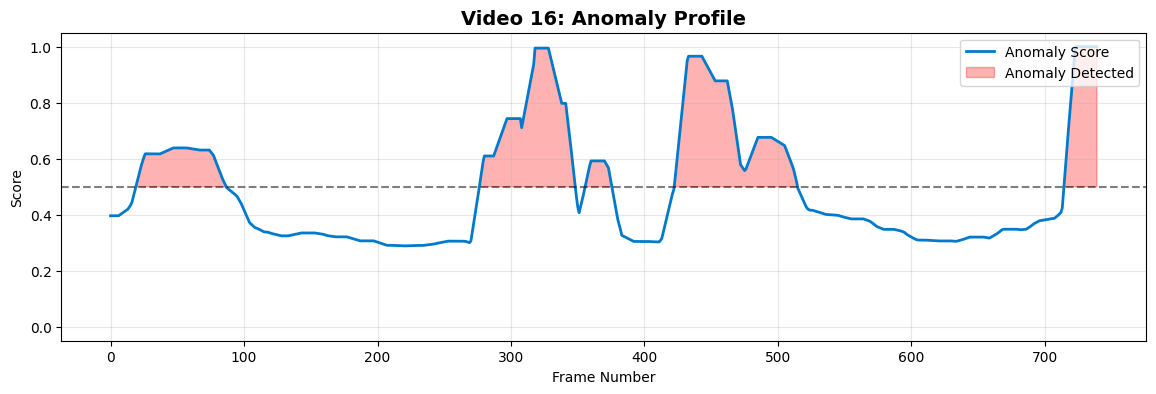

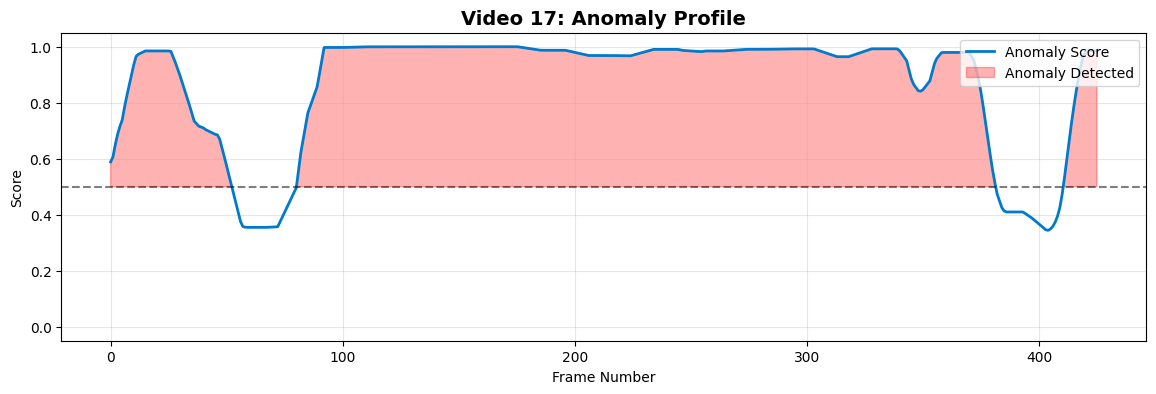

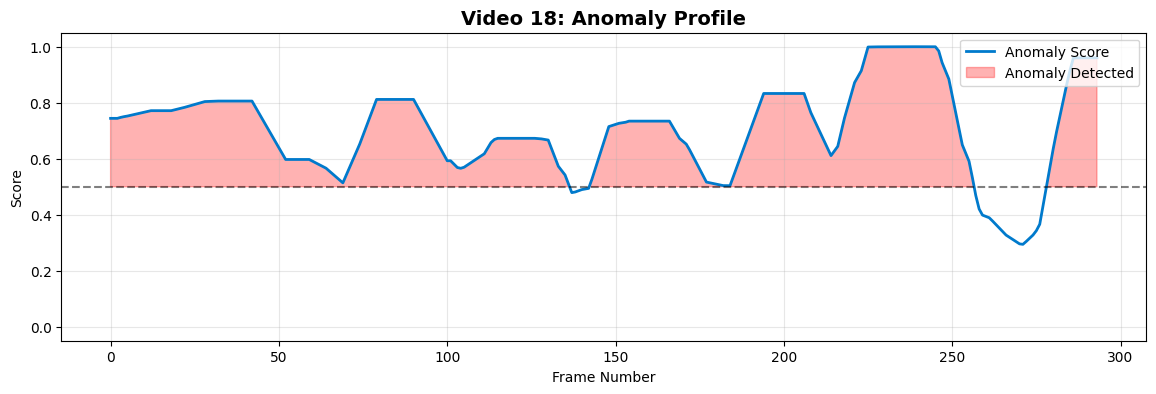

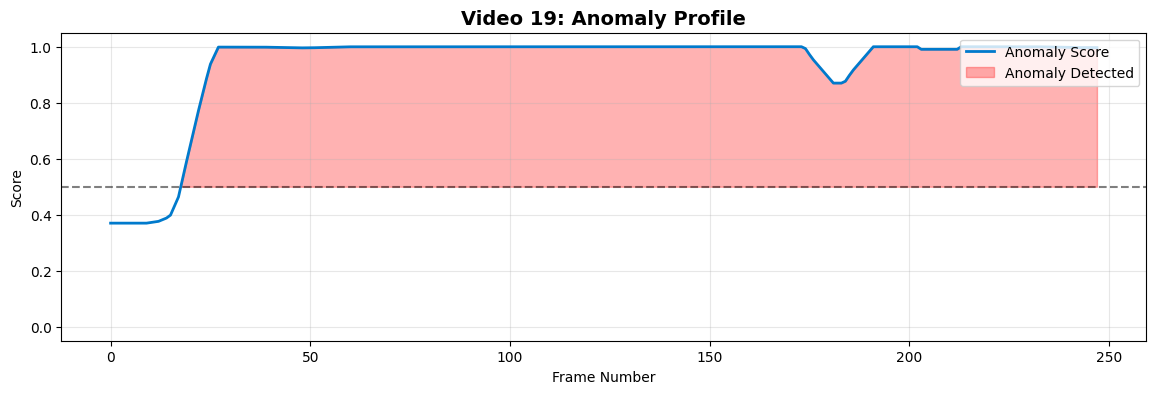

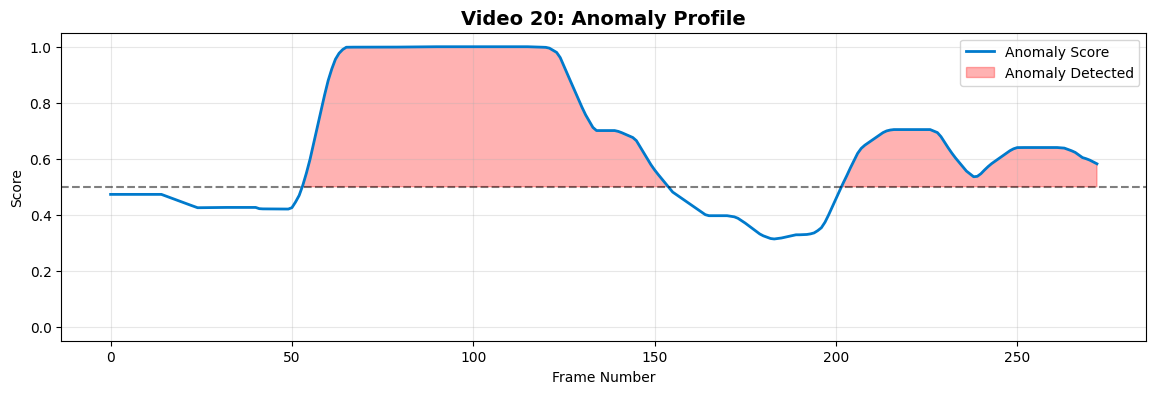

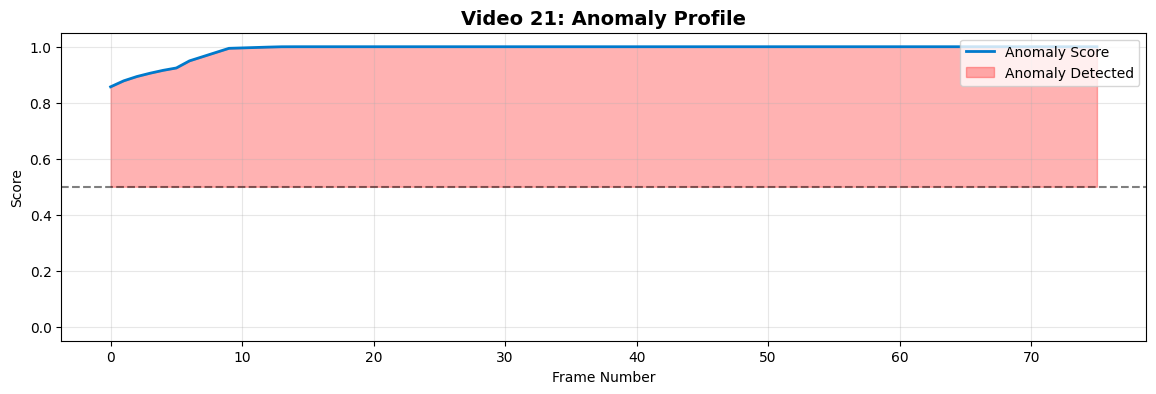

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_boosted_unet.csv'
THRESHOLD = 0.5 
# =================================================

def visualize_inline():
    print(f"📂 Loading {INPUT_CSV}...")
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print("❌ Error: File not found. Did you run the previous step?")
        return

    # 1. Parse 'ID' (e.g., '1_939') back into Video and Frame columns
    print("🔄 Parsing data...")
    split_data = df['ID'].str.split('_', expand=True)
    df['video_id'] = split_data[0].astype(int)
    df['frame_id'] = split_data[1].astype(int)
    
    # 2. Get unique videos
    videos = sorted(df['video_id'].unique())
    print(f"🌍 Visualizing {len(videos)} videos...")
    print("-" * 30)

    # 3. Loop and Plot Inline
    for vid in videos:
        # Filter data for this video
        vid_df = df[df['video_id'] == vid].sort_values(by='frame_id')
        
        frames = vid_df['frame_id'].values
        scores = vid_df['Predicted'].values
        
        # Create Plot
        plt.figure(figsize=(14, 4)) # Wide and short for better scrolling
        
        # Plot the Score Line
        plt.plot(frames, scores, color='#007acc', linewidth=2, label='Anomaly Score')
        
        # Fill area under curve for anomalies (Red Zones)
        plt.fill_between(frames, scores, THRESHOLD, where=(scores >= THRESHOLD), 
                         interpolate=True, color='red', alpha=0.3, label='Anomaly Detected')
        
        # Add Threshold Line
        plt.axhline(y=THRESHOLD, color='black', linestyle='--', alpha=0.5)
        
        # Styling
        plt.title(f"Video {vid}: Anomaly Profile", fontsize=14, fontweight='bold')
        plt.xlabel("Frame Number")
        plt.ylabel("Score")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')
        
        # SHOW PLOT
        plt.show()
        print("\n") # Spacing

if __name__ == "__main__":
    visualize_inline()